In [1]:
# Import necessary libraries
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Additional libraries for confusion matrix, ROC, AUC, and evaluation metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
import seaborn as sns
import pandas as pd

In [2]:

# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Set directory paths
dataset = "C:\\Users\\RoopaGanesh\\Downloads\\Cotton_data"
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

In [4]:
# Batch size and number of classes
bs = 32
num_classes = len(os.listdir(valid_directory))  
print(num_classes)

5


In [5]:
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Mapping of indices to class names
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

{0: 'Aphids', 1: 'Bacterial blight', 2: 'Cotton Boll Rot', 3: 'Healthy', 4: 'Powdery mildew'}


In [6]:
# Load pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)

C:\Users\RoopaGanesh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\RoopaGanesh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

# Change the final layer for transfer learning
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim=1))

# Define optimizer and loss function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())

In [8]:
# Training and validation function
def train_and_validate(model, loss_criterion, optimizer, epochs=5):
    start = time.time()
    history = []
    all_preds = []
    all_labels = []
    all_probs = []

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        model.train()  # Set to training mode
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Getting the probabilities for ROC-AUC
                probs = torch.exp(outputs)
                all_probs.extend(probs.cpu().numpy())

                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s"
              .format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
    return model, history, all_preds, all_labels, all_probs

In [9]:
# Define device and train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 5
trained_model, history, all_preds, all_labels, all_probs = train_and_validate(alexnet.to(device), loss_func, optimizer, num_epochs)

# Save training history
torch.save(history, dataset+'_history.pt')

Epoch: 1/5
Epoch: 001, Training: Loss: 0.2400, Accuracy: 91.9952%, Validation: Loss: 0.1025, Accuracy: 97.6048%, Time: 188.8210s
Epoch: 2/5
Epoch: 002, Training: Loss: 0.0912, Accuracy: 97.0673%, Validation: Loss: 0.0893, Accuracy: 98.2036%, Time: 159.4824s
Epoch: 3/5
Epoch: 003, Training: Loss: 0.0719, Accuracy: 97.4279%, Validation: Loss: 0.1099, Accuracy: 97.6048%, Time: 184.4160s
Epoch: 4/5
Epoch: 004, Training: Loss: 0.0581, Accuracy: 98.1250%, Validation: Loss: 0.0891, Accuracy: 97.6048%, Time: 174.5060s
Epoch: 5/5
Epoch: 005, Training: Loss: 0.0522, Accuracy: 98.3654%, Validation: Loss: 0.0844, Accuracy: 98.2036%, Time: 161.2301s


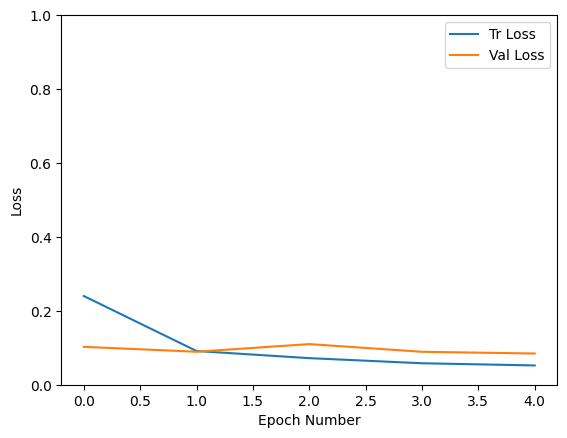

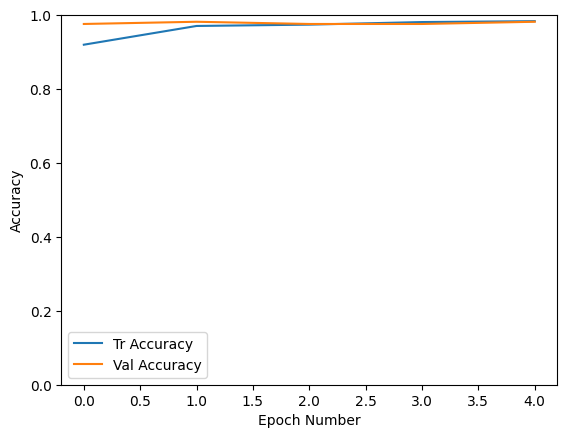

In [10]:
# Convert history to numpy array and plot loss and accuracy
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

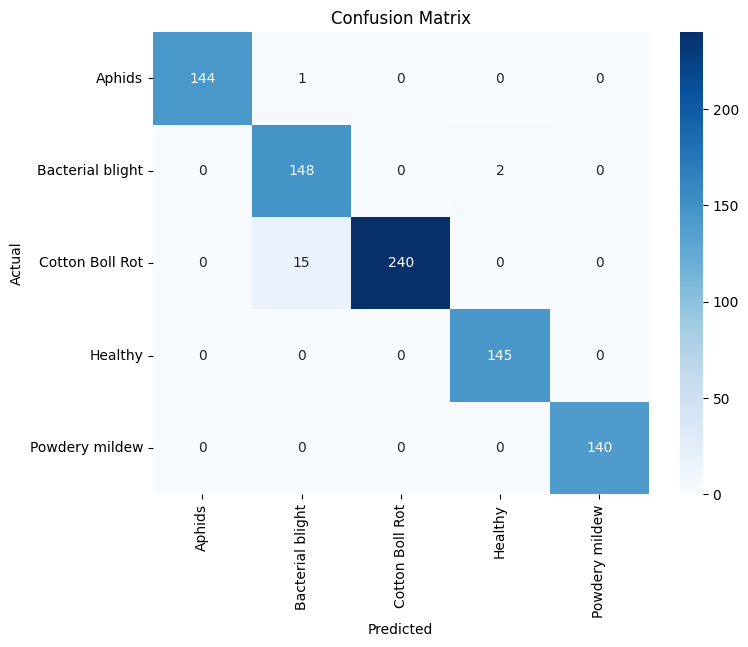


Classification Report:
                   precision    recall  f1-score   support

          Aphids       1.00      0.99      1.00       145
Bacterial blight       0.90      0.99      0.94       150
 Cotton Boll Rot       1.00      0.94      0.97       255
         Healthy       0.99      1.00      0.99       145
  Powdery mildew       1.00      1.00      1.00       140

        accuracy                           0.98       835
       macro avg       0.98      0.98      0.98       835
    weighted avg       0.98      0.98      0.98       835



In [11]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=[idx_to_class[i] for i in range(num_classes)],
                     columns=[idx_to_class[i] for i in range(num_classes)])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[idx_to_class[i] for i in range(num_classes)]))

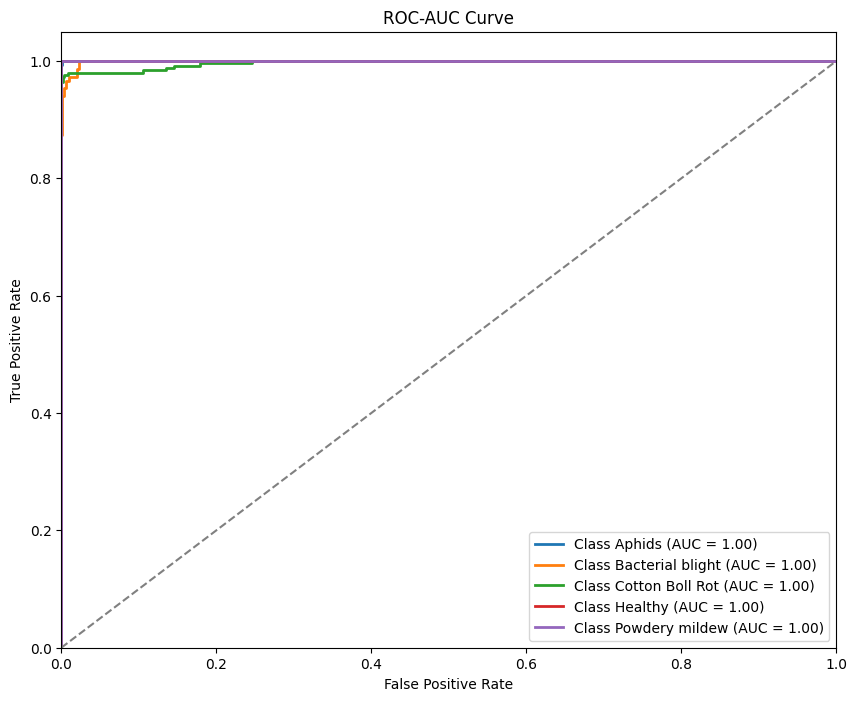

ROC-AUC Macro: 0.9992
ROC-AUC Weighted: 0.9989


In [12]:

# ROC-AUC Curve and Score for each class
all_probs = np.array(all_probs)
all_labels_one_hot = np.eye(num_classes)[all_labels]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='Class {} (AUC = {:.2f})'.format(idx_to_class[i], roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# AUC Score for macro and weighted average
roc_auc_macro = roc_auc_score(all_labels_one_hot, all_probs, average='macro')
roc_auc_weighted = roc_auc_score(all_labels_one_hot, all_probs, average='weighted')
print(f"ROC-AUC Macro: {roc_auc_macro:.4f}")
print(f"ROC-AUC Weighted: {roc_auc_weighted:.4f}")

In [13]:
# Prediction on a single test image
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(5, dim=1)
        for i in range(5):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])


Prediction 1 : Aphids , Score:  0.99981993
Prediction 2 : Cotton Boll Rot , Score:  0.00015634016
Prediction 3 : Powdery mildew , Score:  1.7548862e-05
Prediction 4 : Bacterial blight , Score:  5.3473505e-06
Prediction 5 : Healthy , Score:  8.001967e-07


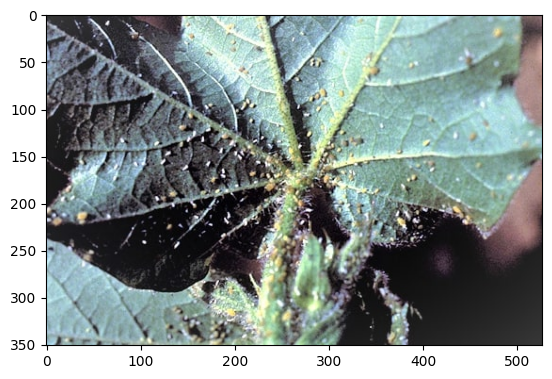

In [14]:
# Example prediction
predict(trained_model, "C:\\Users\\RoopaGanesh\\Downloads\\Cotton_data\\valid\\Aphids\\6.jpg")